In [2]:
import jax.numpy as jnp
from syuron import shg, mgoslt, pp
import jax
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

PERIOD = 7.2  # グレーティング周期
KAPPA = 1.038E-05
TEMP = [65.0, 70.0, 75.0]
DEVICE_LENGTH = 5000  # デバイス長
PERIOD = 7.2  # グレーティング周期
DOMAIN_WIDTH = PERIOD/2

WAVELENGTH_RANGE = jnp.linspace(
    1.031-0.002, 1.031+0.002, 1000).tolist()  # 中心波長1030nm周辺

# (2, 1388, 2)で、([structure1, structure2], [...domains], [幅, 符号がついたkappa値])
structure = pp.fixed(
    int(DEVICE_LENGTH/DOMAIN_WIDTH), [DOMAIN_WIDTH, DOMAIN_WIDTH], KAPPA
)

# structure[1, :, 1]で、2番目の構造とkappa値のindexを指定
# int(len * 0.165)以降の符号をすべて反転
idx = int(structure.shape[1] * 0.165)
structure = structure.at[1, idx:, 1].set(-structure[1, idx:, 1])

In [3]:
phase_mismatch_fn = mgoslt.use_material(jnp.array(1), jnp.array(70))
a = phase_mismatch_fn(1)
print(a)

0.9593627656962056


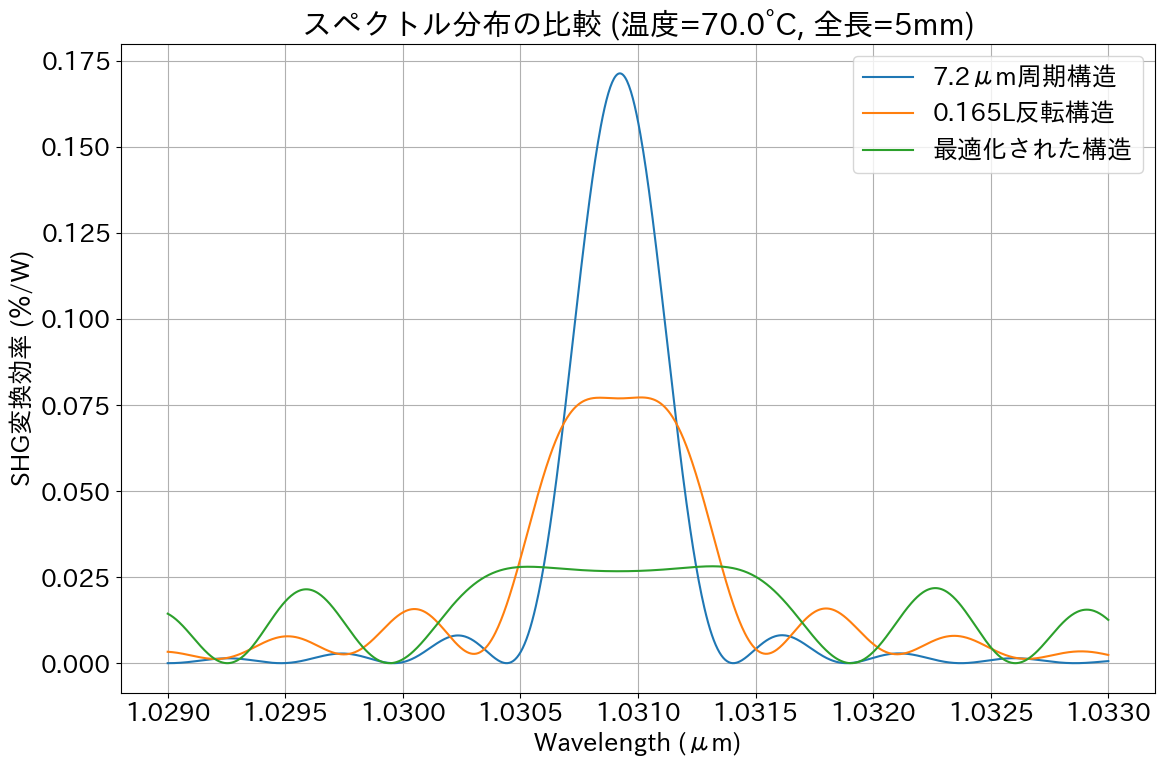

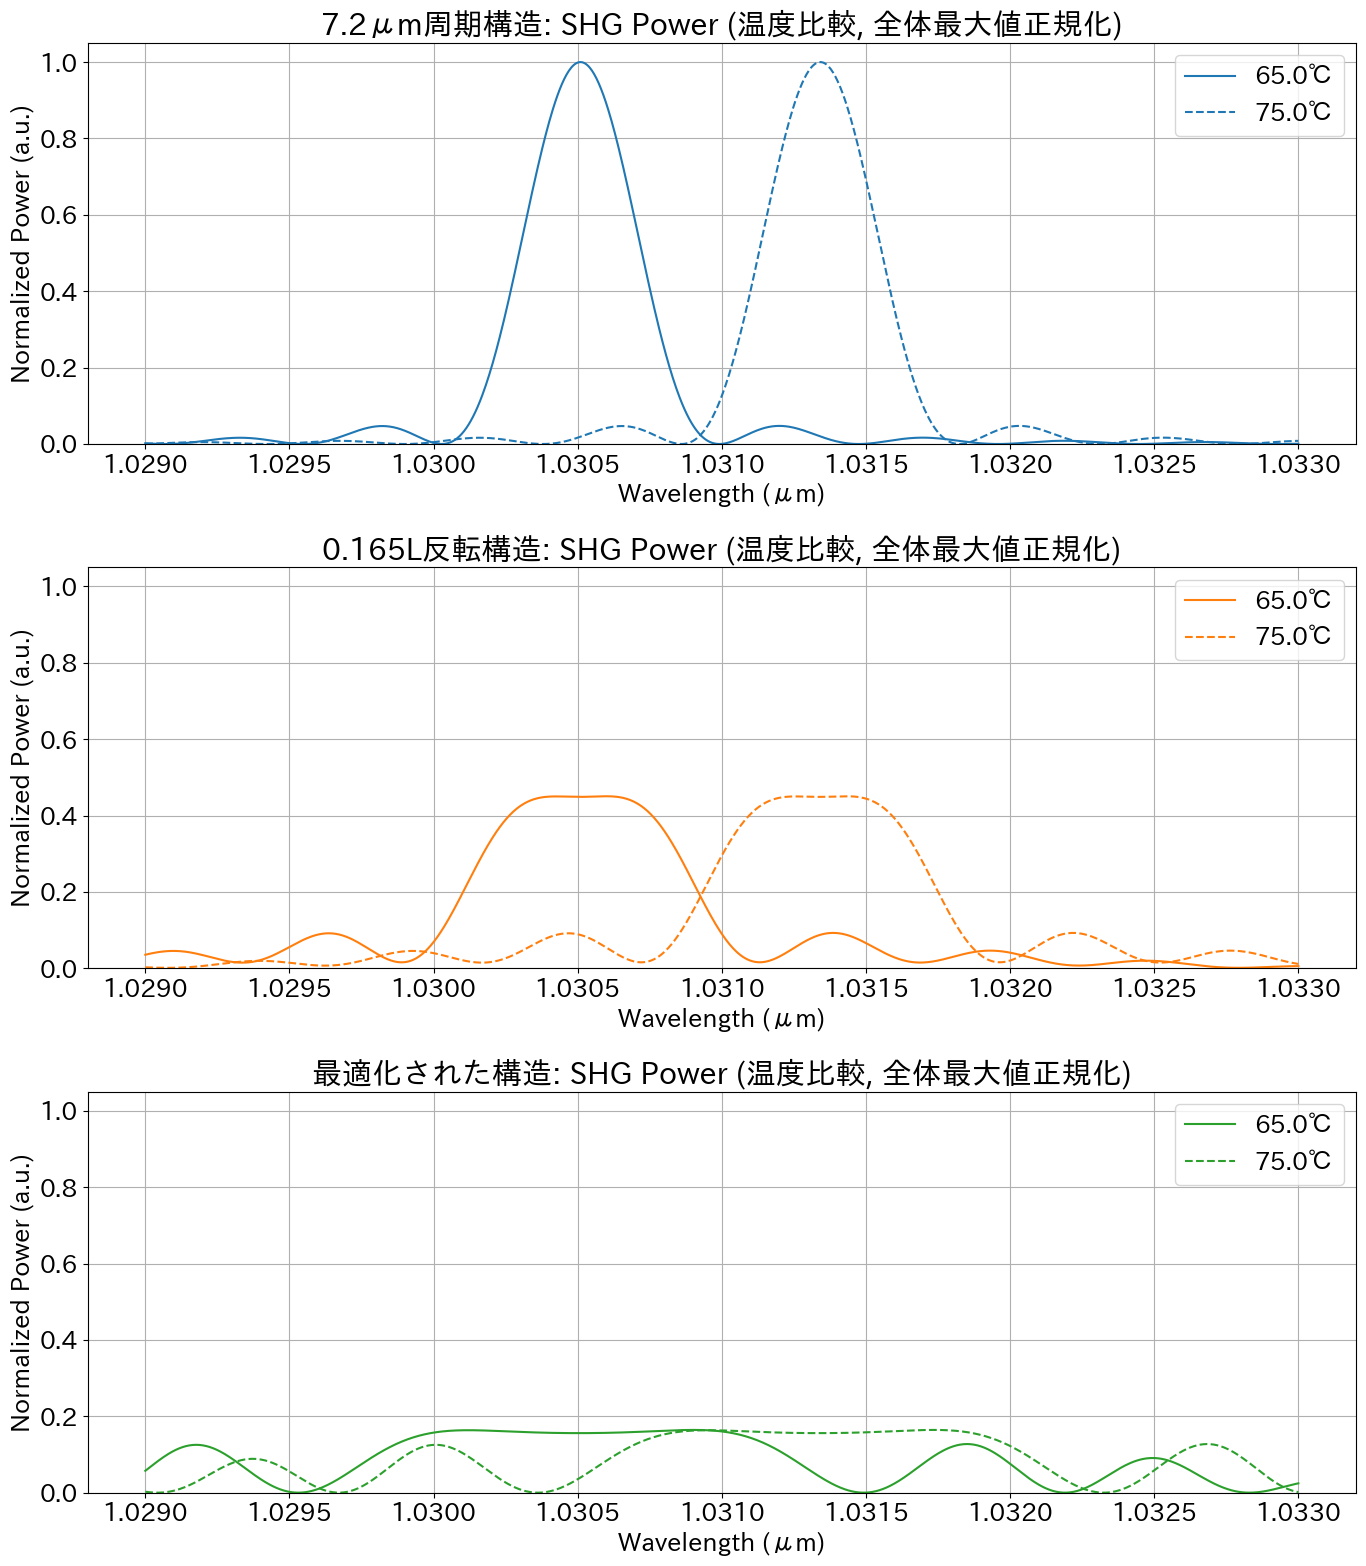

In [4]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from syuron import shg, mgoslt, pp

# 定数の定義
NUM_DOMAINS = int(DEVICE_LENGTH / DOMAIN_WIDTH)  # 1388
POINTS_PER_DOMAIN = 36  # 1ドメインあたりの信号点数 (50000 / 1388 の整数部)
TOTAL_POINTS = NUM_DOMAINS * POINTS_PER_DOMAIN  # 49968

# 最適化された信号をロード
optimized_signal = jnp.load("optimized_const_signal_8.npy")

# 信号を(1388, 36)の形状に整形
signal_reshaped = jnp.reshape(
    optimized_signal[:TOTAL_POINTS], (NUM_DOMAINS, POINTS_PER_DOMAIN))

# 各ドメインの符号を決定 (最初の点の符号を代表とする)
domain_signs = signal_reshaped[:, 0]

# 最適化構造を組み立てる
# 1列目: ドメイン幅 (すべて一定)
optimized_widths = jnp.full((NUM_DOMAINS,), DOMAIN_WIDTH)
# 2列目: 符号付きKappa
optimized_kappas = domain_signs * KAPPA
# 結合して (1388, 2) の配列にする
optimized_structure_single = jnp.stack(
    [optimized_widths, optimized_kappas], axis=1)

# --- 解析とプロット --- #

# 既存の構造と新しい最適化構造を結合
# (2, 1388, 2) と (1388, 2) -> (3, 1388, 2) にする
optimized_structure_reshaped = jnp.expand_dims(
    optimized_structure_single, axis=0)  # (1, 1388, 2) に変換
combined_structure = jnp.concatenate(
    [structure, optimized_structure_reshaped], axis=0)

# 解析実行
result_combined = mgoslt.analyze(
    shg.Params(
        grating_dim=combined_structure,
        T_dim=TEMP,
        wavelength_dim=WAVELENGTH_RANGE,
        fund_power_dim=1
    )
)


# power_combined: intensity (|E|^2)
power_combined = (jnp.abs(result_combined)**2).squeeze()

# --- 全体最大値で正規化したプロット（軸を揃える） --- #
# Amplitude, Power それぞれ全構造・全温度で最大値を取得
# colors_structuresとlabels_structuresが未定義の場合はここで定義
colors_structures = ['tab:blue', 'tab:orange', 'tab:green']
labels_structures = ['7.2μm周期構造', '0.165L反転構造', '最適化された構造']
plt.rcParams['font.size'] = 18  # フォントサイズを大きく設定

# linestylesも未定義の場合はここで定義
linestyles = ['-', '--']

global_max_amp = jnp.max(power_combined)
fig_amp, ax_amp = plt.subplots(figsize=(12, 8))
for i in range(3):  # 構造ごと
    ax_amp.plot(
        WAVELENGTH_RANGE,
        power_combined[i, 1] / global_max_amp * 0.17136087,
        label=labels_structures[i],
        color=colors_structures[i]
    )
ax_amp.set_xlabel("Wavelength (μm)")
ax_amp.set_ylabel("SHG変換効率 (％/W)")
ax_amp.set_title("スペクトル分布の比較 (温度=%.1f°C, 全長=5mm)" % TEMP[1])
ax_amp.grid(True)
ax_amp.legend()
# ax_amp.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Power: 各構造ごとに温度比較
global_max_pow = jnp.max(power_combined)
fig2, axs2 = plt.subplots(3, 1, figsize=(14, 16))
for i in range(3):  # 構造ごと
    for j, t in enumerate([0, 2]):
        axs2[i].plot(
            WAVELENGTH_RANGE,
            power_combined[i, t] / global_max_pow,
            label=f"{TEMP[t]:.1f}℃",
            color=colors_structures[i],
            linestyle=linestyles[j]
        )
    axs2[i].set_xlabel("Wavelength (μm)")
    axs2[i].set_ylabel("Normalized Power (a.u.)")
    axs2[i].set_title(f"{labels_structures[i]}: SHG Power (温度比較, 全体最大値正規化)")
    axs2[i].grid(True)
    axs2[i].legend()
    axs2[i].set_ylim(0, 1.05)
plt.tight_layout()
plt.show()


最適化信号から逆算した結果 (量子化後):
  - 実効ドメイン数: 1389
  - 実効デバイス長: 5000.40 µm


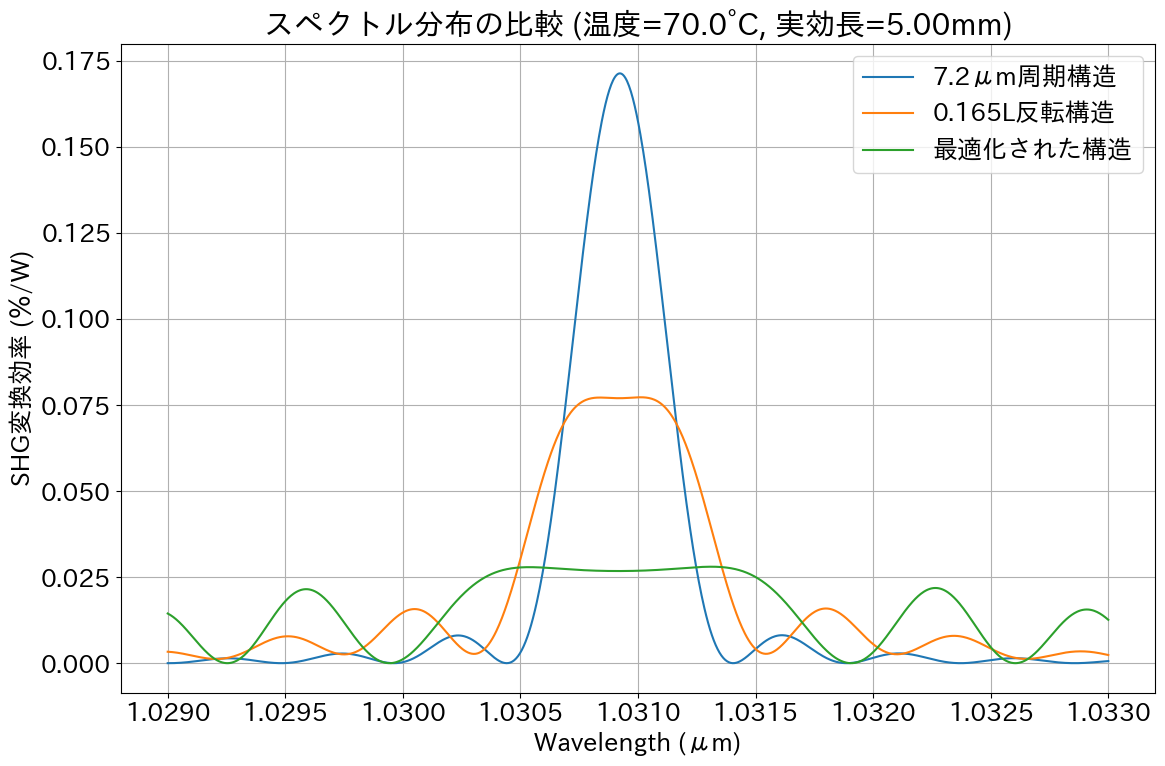

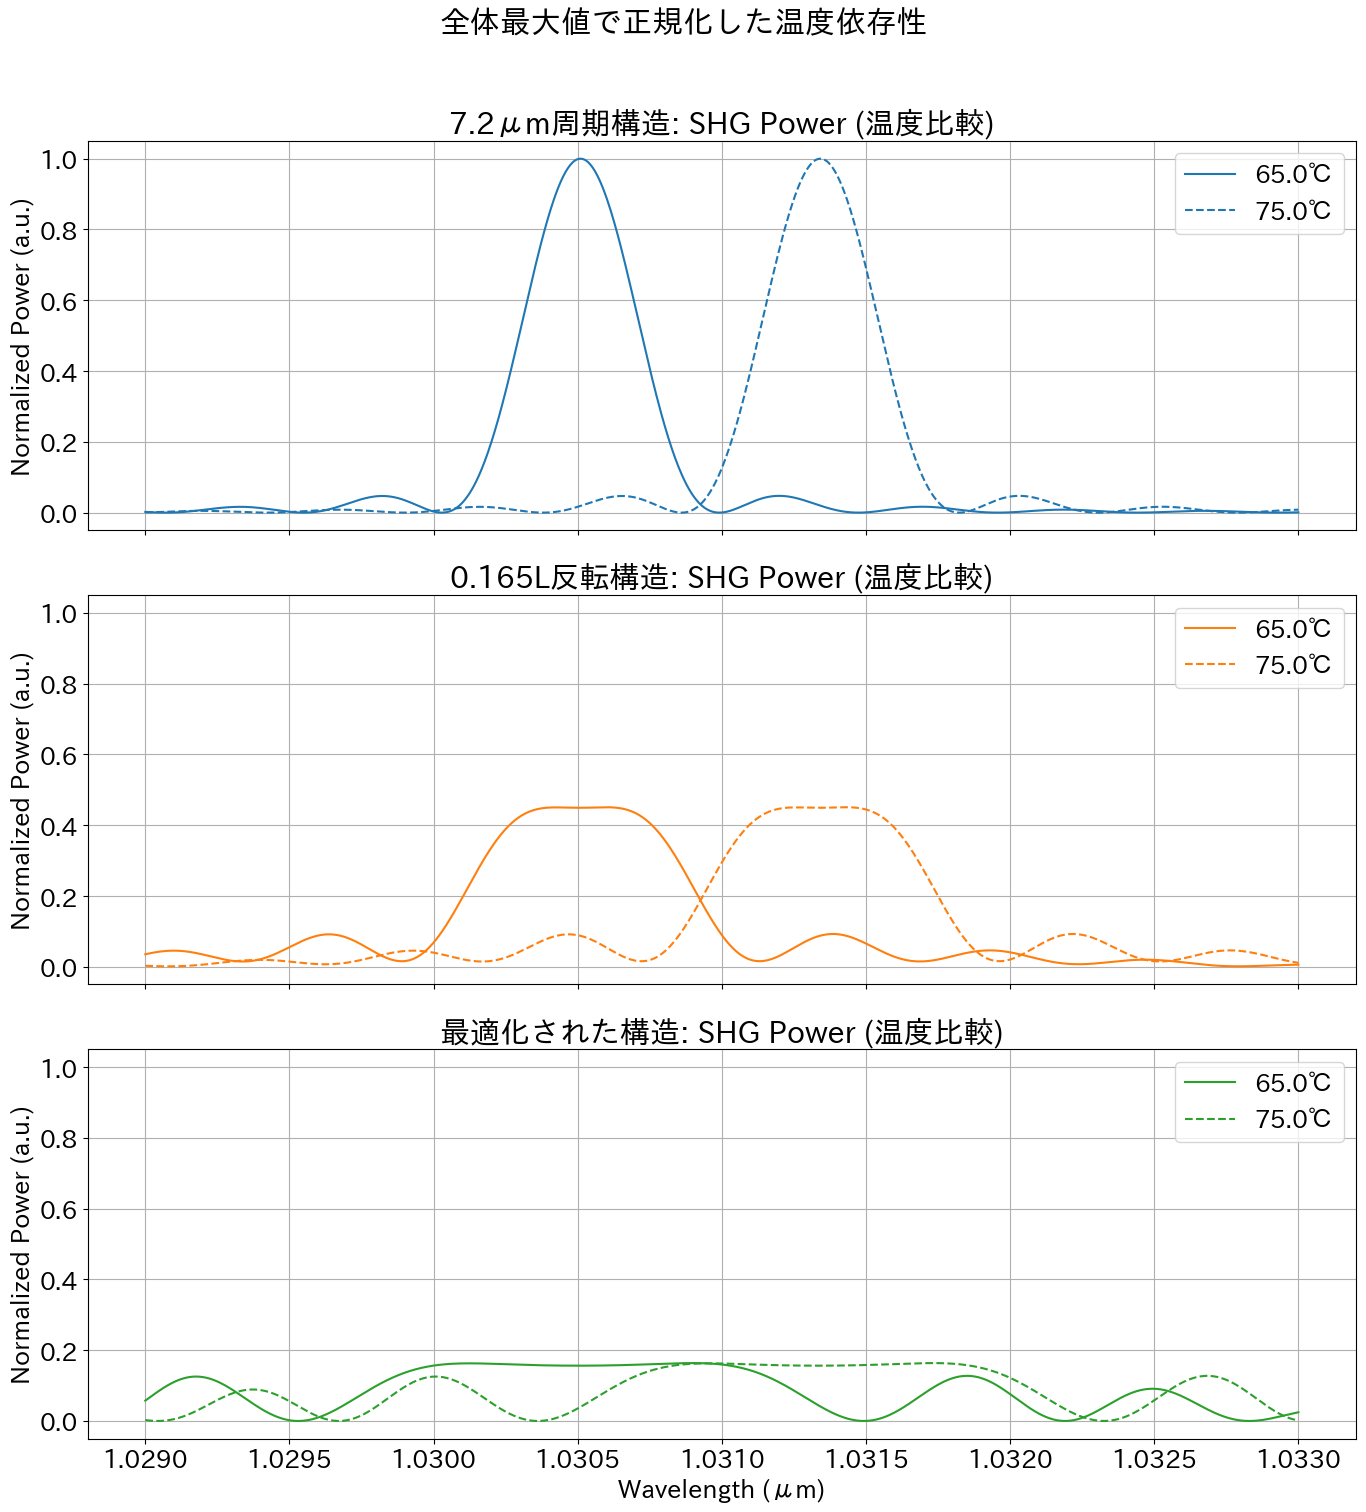

In [5]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from syuron import shg, mgoslt, pp

# 1. 最適化された信号をロード
optimized_signal = jnp.load("optimized_const_signal_8.npy")
OPTIMIZED_SIGNAL_LENGTH = len(optimized_signal)

# 2. 信号からドメイン構造（符号の連続区間）を抽出
signed_signal = jnp.sign(optimized_signal)
signed_signal = jnp.where(signed_signal == 0, 1.0, signed_signal)  # ゼロは+1とする

change_points = jnp.where(jnp.diff(signed_signal) != 0)[0] + 1
boundaries = jnp.concatenate(
    [jnp.array([0]), change_points, jnp.array([OPTIMIZED_SIGNAL_LENGTH])])

# 3. 物理単位への量子化スケールを計算
# 理論上のドメイン数を基準に、1物理ドメイン(3.6um)あたりの信号点数を計算
initial_num_domains_theory = int(DEVICE_LENGTH / DOMAIN_WIDTH)
points_per_unit_width = OPTIMIZED_SIGNAL_LENGTH / initial_num_domains_theory

# 4. 各信号ドメインを量子化し、最終的な物理ドメインのリストを生成
final_structure_list = []
for i in range(len(boundaries) - 1):
    start_point = boundaries[i]
    end_point = boundaries[i+1]

    # 信号ドメインの情報を取得
    domain_length_in_points = end_point - start_point
    domain_sign = signed_signal[start_point]

    # 信号ドメインの長さを、物理ドメイン(3.6um)の個数に量子化
    num_physical_domains = int(
        round(domain_length_in_points / points_per_unit_width))

    # 量子化の結果が0個になるのを防ぐ（最低1個は割り当てる）
    if num_physical_domains == 0:
        num_physical_domains = 1

    # 量子化された個数分、同じ符号の物理ドメイン([幅, 符号付きKappa])をリストに追加
    for _ in range(num_physical_domains):
        final_structure_list.append([DOMAIN_WIDTH, domain_sign * KAPPA])

# 5. リストから最終的な構造配列を生成
optimized_structure_single = jnp.array(final_structure_list)

# 6. データから実際のドメイン数と実効長を決定
NUM_DOMAINS = len(optimized_structure_single)
EFFECTIVE_DEVICE_LENGTH = NUM_DOMAINS * DOMAIN_WIDTH
print(f"\n最適化信号から逆算した結果 (量子化後):")
print(f"  - 実効ドメイン数: {NUM_DOMAINS}")
print(f"  - 実効デバイス長: {EFFECTIVE_DEVICE_LENGTH:.2f} µm")

# 7. 【修正点】データに基づいたドメイン数で、比較用の基本構造を再生成する
structure = pp.fixed(
    NUM_DOMAINS, [DOMAIN_WIDTH, DOMAIN_WIDTH], KAPPA
)
# 2番目の構造の0.165L以降の符号をすべて反転
idx = int(structure.shape[1] * 0.165)
structure = structure.at[1, idx:, 1].set(-structure[1, idx:, 1])


# --- 解析とプロット (変更なし) ---

# 既存の構造と新しい最適化構造を結合
optimized_structure_reshaped = jnp.expand_dims(
    optimized_structure_single, axis=0)  # (1, NUM_DOMAINS, 2) に変換
combined_structure = jnp.concatenate(
    [structure, optimized_structure_reshaped], axis=0)

# 解析実行
result_combined = mgoslt.analyze(
    shg.Params(
        grating_dim=combined_structure,
        T_dim=TEMP,
        wavelength_dim=WAVELENGTH_RANGE,
        fund_power_dim=1
    )
)

# power_combined: intensity (|E|^2)
power_combined = (jnp.abs(result_combined)**2).squeeze()

# --- 全体最大値で正規化したプロット（軸を揃える） ---
colors_structures = ['tab:blue', 'tab:orange', 'tab:green']
labels_structures = ['7.2μm周期構造', '0.165L反転構造', '最適化された構造']
plt.rcParams['font.size'] = 18

linestyles = ['-', '--']

global_max_amp = jnp.max(power_combined)
fig_amp, ax_amp = plt.subplots(figsize=(12, 8))
for i in range(3):  # 構造ごと
    ax_amp.plot(
        WAVELENGTH_RANGE,
        power_combined[i, 1] / global_max_amp * 0.17136087,  # SHG効率に変換
        label=labels_structures[i],
        color=colors_structures[i]
    )
ax_amp.set_xlabel("Wavelength (μm)")
ax_amp.set_ylabel("SHG変換効率 (％/W)")
ax_amp.set_title(
    f"スペクトル分布の比較 (温度={TEMP[1]:.1f}°C, 実効長={EFFECTIVE_DEVICE_LENGTH/1000:.2f}mm)")
ax_amp.grid(True)
ax_amp.legend()
plt.tight_layout()
plt.show()

# --- 温度比較プロット ---
global_max_pow = jnp.max(power_combined)
fig2, axs2 = plt.subplots(3, 1, figsize=(14, 16), sharex=True, sharey=True)
for i in range(3):  # 構造ごと
    for j, t_idx in enumerate([0, 2]):  # 65度と75度をプロット
        axs2[i].plot(
            WAVELENGTH_RANGE,
            power_combined[i, t_idx] / global_max_pow,
            label=f"{TEMP[t_idx]:.1f}℃",
            color=colors_structures[i],
            linestyle=linestyles[j]
        )
    axs2[i].set_ylabel("Normalized Power (a.u.)")
    axs2[i].set_title(f"{labels_structures[i]}: SHG Power (温度比較)")
    axs2[i].grid(True)
    axs2[i].legend()


axs2[2].set_xlabel("Wavelength (μm)")  # 一番下のプロットにのみX軸ラベルを表示
fig2.suptitle("全体最大値で正規化した温度依存性", fontsize=22)
fig2.tight_layout(rect=[0, 0.03, 1, 0.97])  # suptitleとの重なりを調整
plt.show()

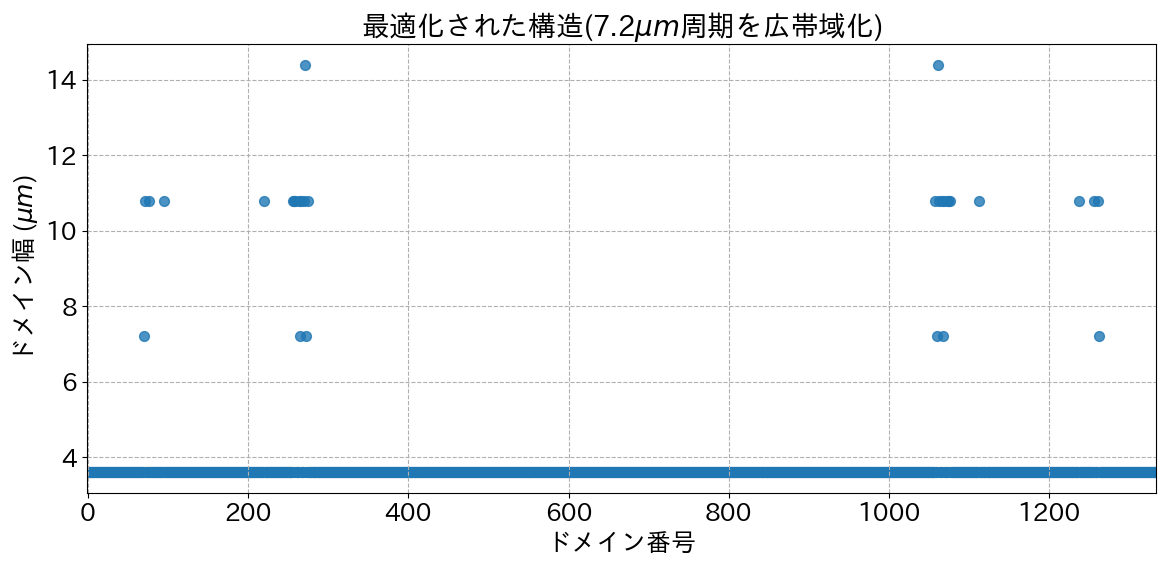

In [10]:
import numpy as np
import matplotlib.pyplot as plt
macro_domain_widths = []

# 信号ドメインから物理ドメインへの量子化を行い、各マクロドメインの幅を順番に記録
for i in range(len(boundaries) - 1):
    start_point = boundaries[i]
    end_point = boundaries[i+1]
    domain_length_in_points = end_point - start_point

    # 物理ドメイン数へ量子化
    num_physical_domains = int(
        round(domain_length_in_points / points_per_unit_width))
    if num_physical_domains == 0:
        num_physical_domains = 1

    # 各「同符号ドメイン」の物理的な幅を計算してリストに追加
    macro_domain_widths.append(num_physical_domains * DOMAIN_WIDTH)


# ドメイン幅のシーケンスを散布図でプロット

# X軸: マクロドメインの通し番号 (0から始まるインデックス)
domain_indices = np.arange(len(macro_domain_widths))

plt.figure(figsize=(12, 6))
# 散布図（点）でプロット。sでマーカーサイズを調整できます。
plt.scatter(domain_indices, macro_domain_widths, s=50, alpha=0.8)

# オプション：点を線で結ぶと変化が分かりやすい場合もあります
# plt.plot(domain_indices, macro_domain_widths, marker='o', linestyle='-', alpha=0.7)

plt.title(r"最適化された構造(7.2$\mu m$周期を広帯域化)", fontsize=20)
plt.xlabel("ドメイン番号", fontsize=18)
plt.ylabel(r"ドメイン幅 ($\mu m$)", fontsize=18)
plt.grid(True, linestyle='--')
plt.xlim(-1, len(domain_indices))  # X軸の表示範囲を調整
plt.tight_layout()
plt.show()